# Recognizing Speaker Emotion

In [2]:
# read audio files
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import MinMaxScaler

## Load Files

Analyzing sad test file: YAF_yes_sad.wav


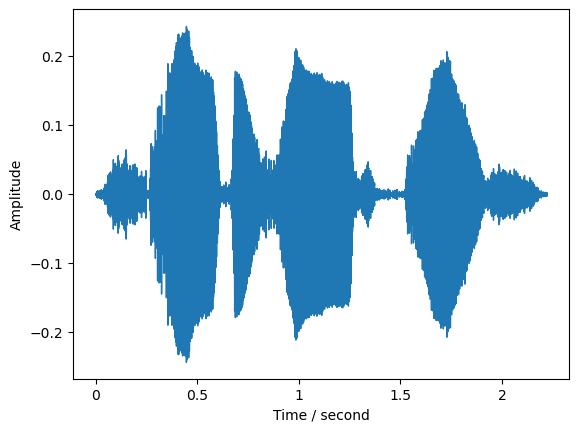

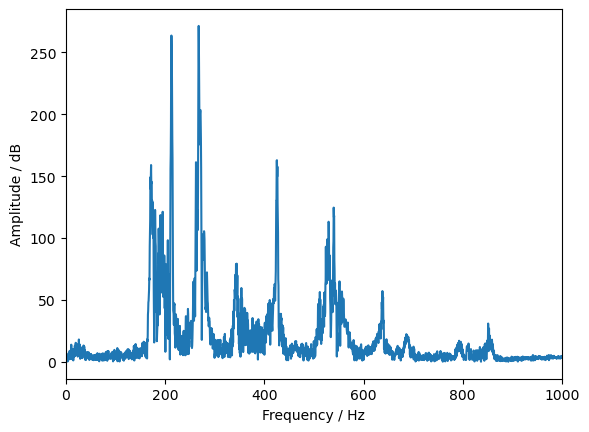

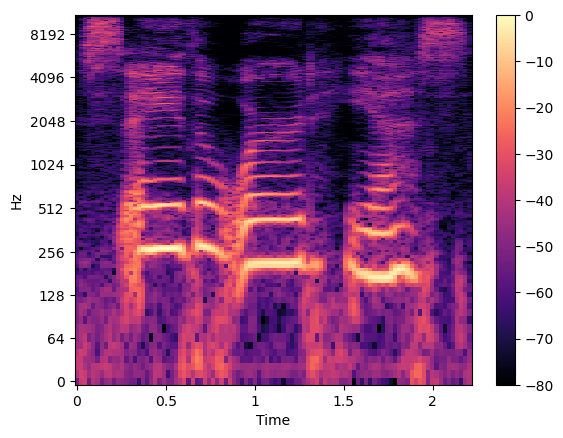





Analyzing happy test file: YAF_should_happy.wav


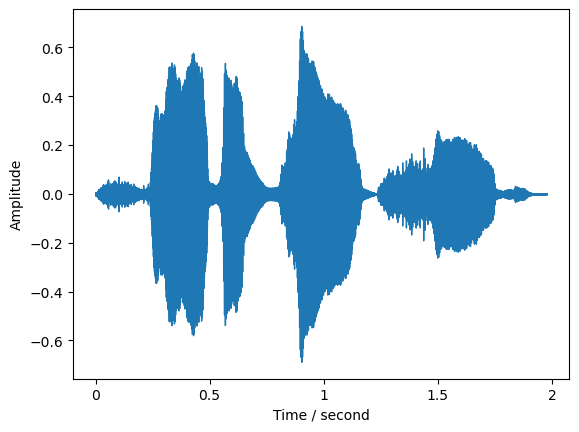

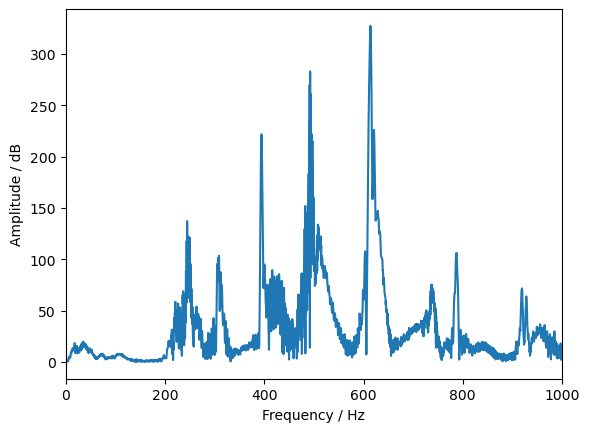

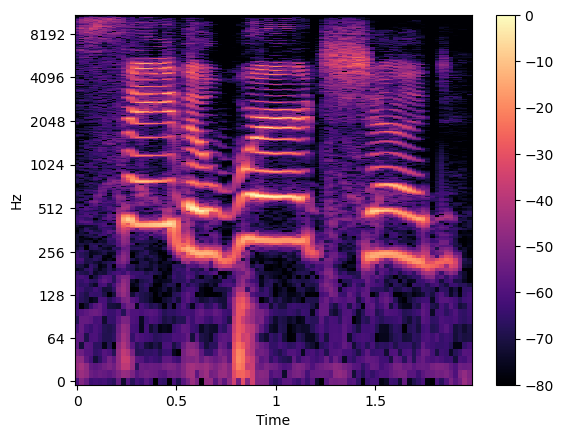





Analyzing fear test file: YAF_mode_fear.wav


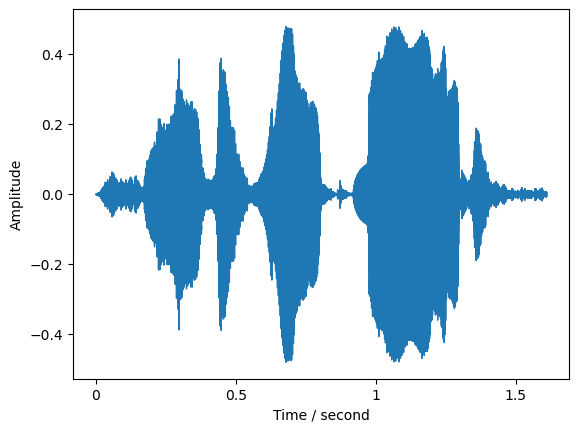

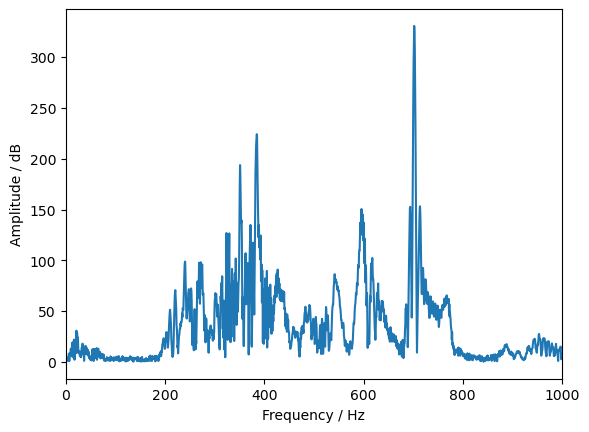

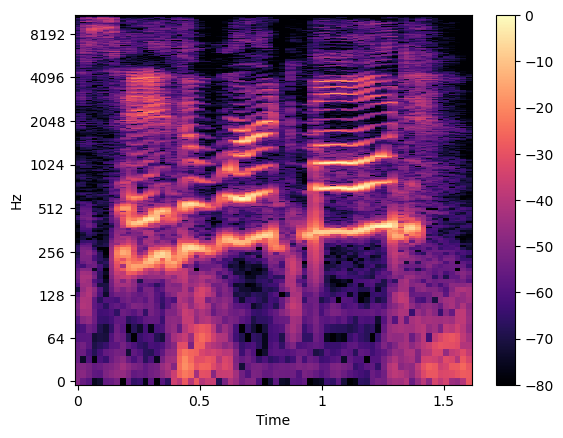





Analyzing angry test file: YAF_walk_angry.wav


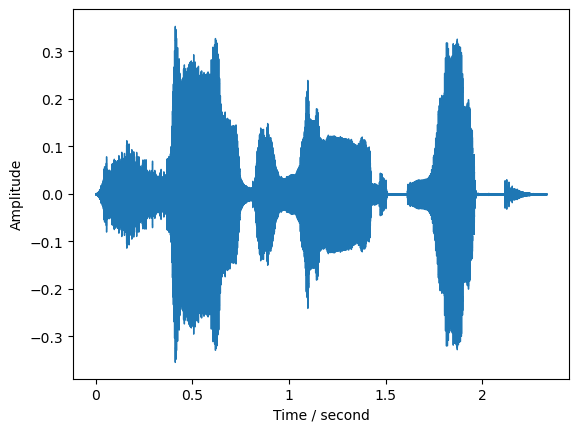

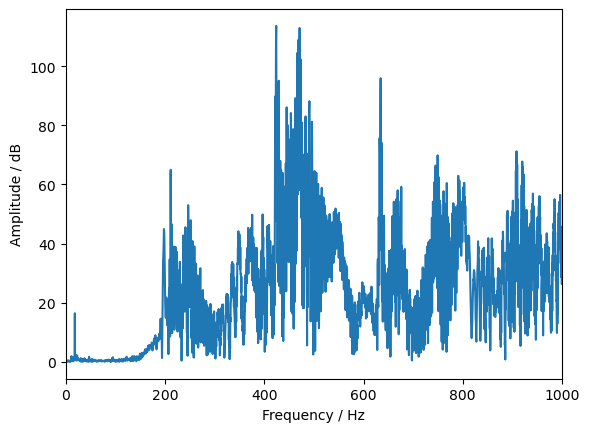

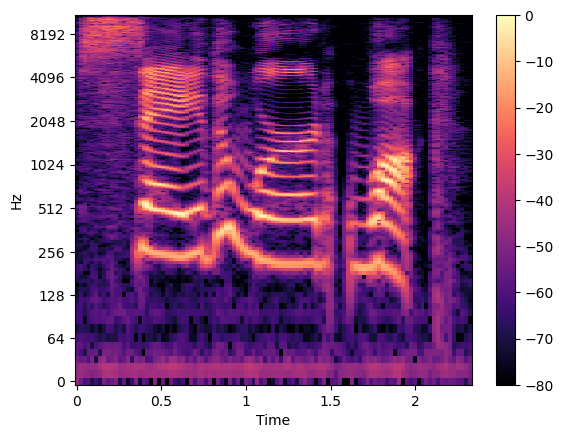

Analyzing sad test file: YAF_nag_sad.wav


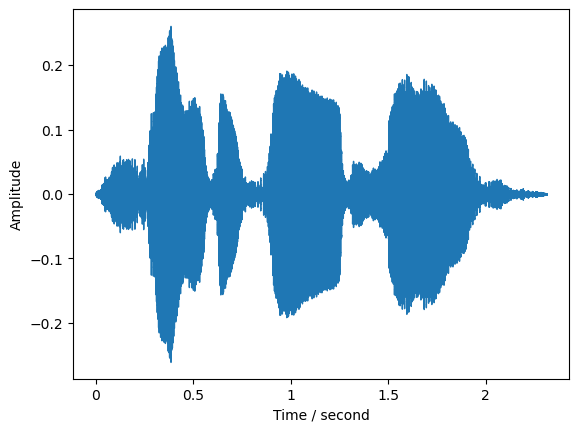

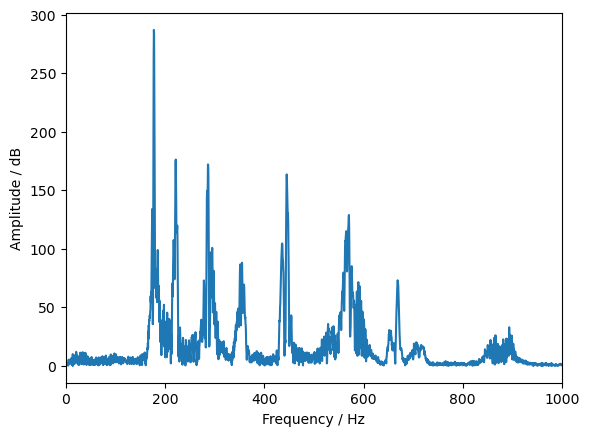

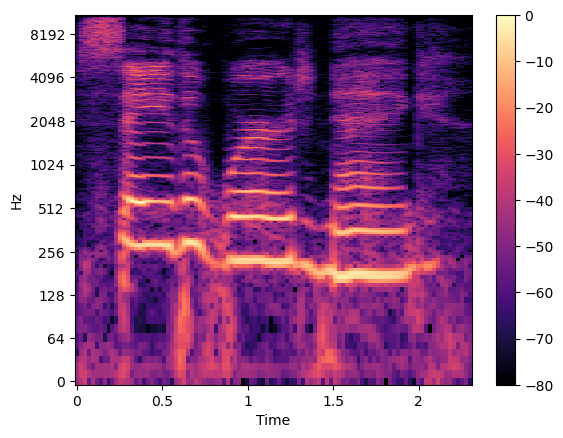





Analyzing happy test file: YAF_sail_happy.wav


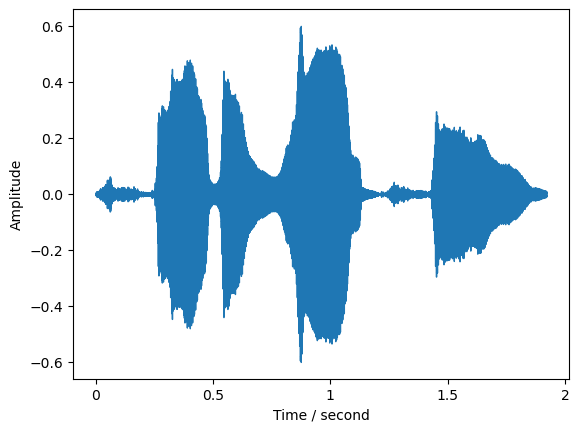

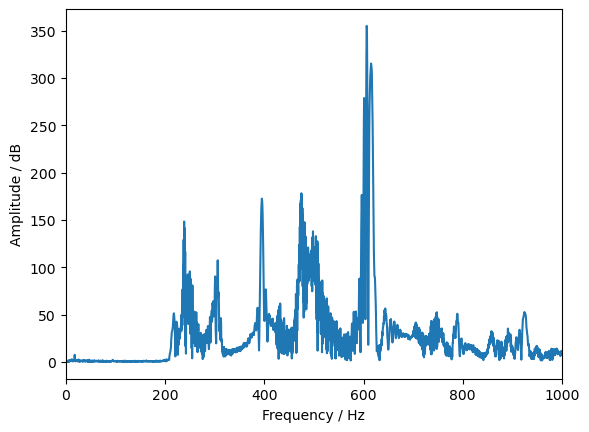

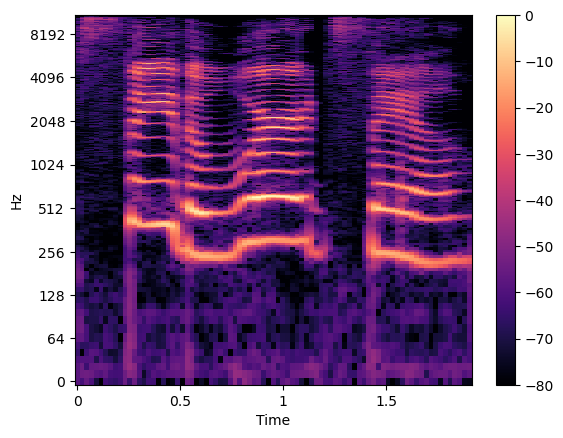





Analyzing fear test file: YAF_rose_fear.wav


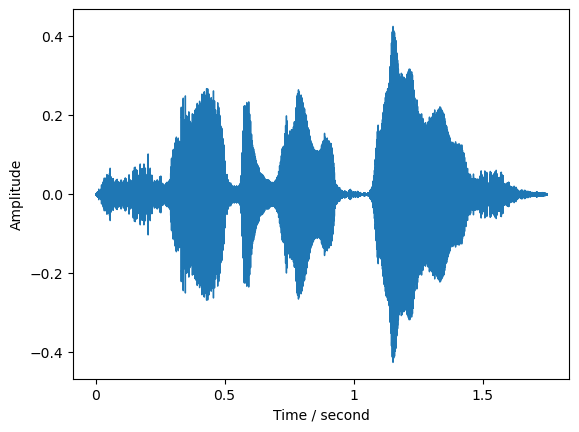

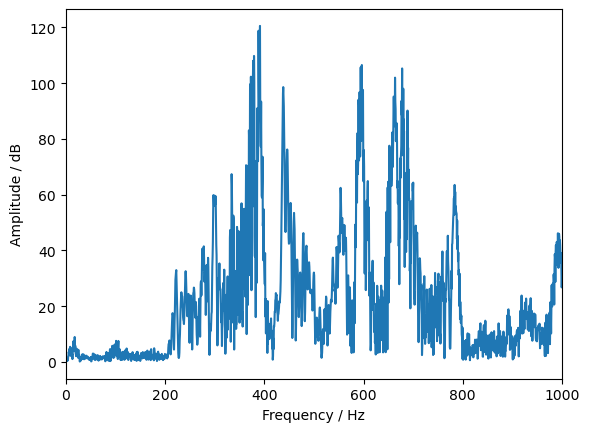

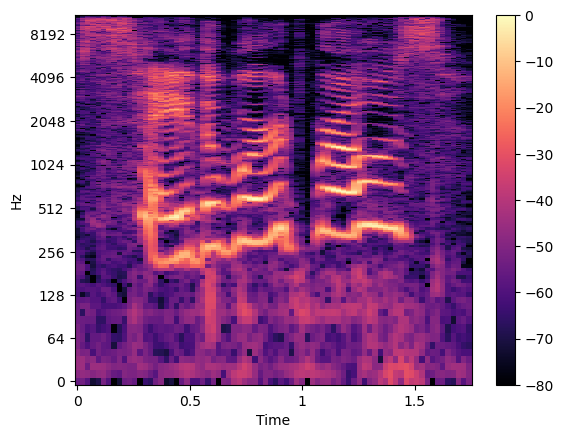





Analyzing angry test file: YAF_pike_angry.wav


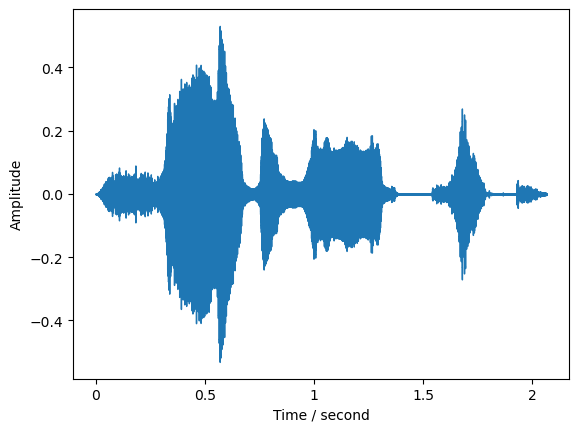

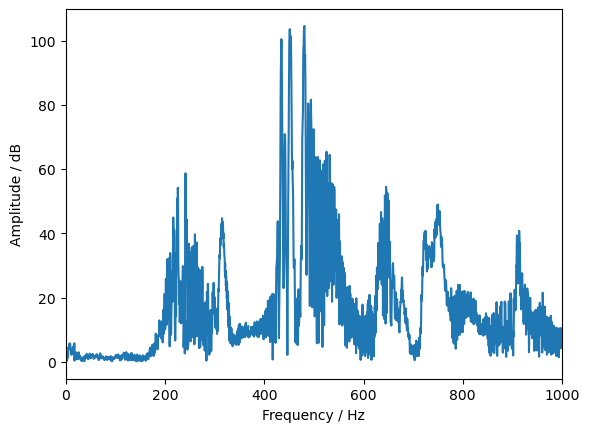

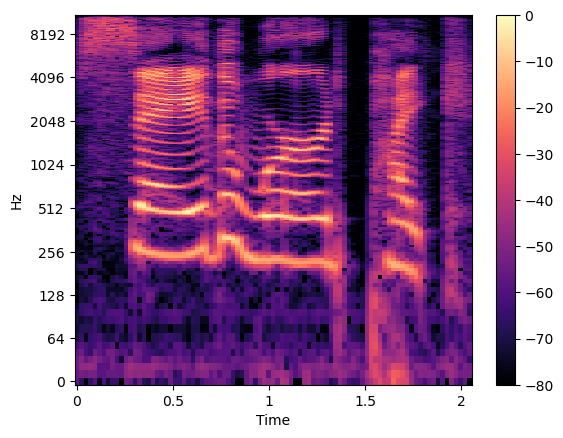

In [3]:
def load_audio_files(data_path, num_train):
    all_files = os.listdir(data_path)
    random.shuffle(all_files)
    train_files = all_files[:num_train] # 70% of the data is used for training
    test_files = all_files[num_train:] # 30% of the data is used for testing
    return train_files, test_files

data_path_sad = './sad/'
data_path_happy = './happy/'
data_path_fear = './fear/'
data_path_angry = './angry/'

num_train = 70

sad_train, sad_test = load_audio_files(data_path_sad, num_train)
happy_train, happy_test = load_audio_files(data_path_happy, num_train)
fear_train, fear_test = load_audio_files(data_path_fear, num_train)
angry_train, angry_test = load_audio_files(data_path_angry, num_train)

def analyze_audio_file(audio_file):
    # load audio files with librosa
    signal, sample_rate = librosa.load(audio_file)

    # plot amplitude vs time
    plt.figure(1)
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.show()

    # plot audio files in frequency domain
    k = np.arange(len(signal)) # length of the signal
    T = len(signal) / sample_rate # duration of the signal
    freq = k / T 

    DATA_0 = np.fft.fft(signal) # fft computing and normalization
    abs_DATA_0 = abs(DATA_0) # calculate the absolute value of the fft
    plt.figure(2)
    plt.plot(freq, abs_DATA_0)
    plt.xlabel("Frequency / Hz")
    plt.ylabel("Amplitude / dB")
    plt.xlim([0, 1000])
    plt.show()

    # plot the time-frequency variation of the audio
    D = librosa.stft(signal)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # convert an amplitude spectrogram to dB-scaled spectrogram
    plt.figure(3)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()

# Analyze a few testing files from each category
num_test_files_to_analyze = 2

for i in range(num_test_files_to_analyze):
    print("Analyzing sad test file:", sad_test[i])
    analyze_audio_file(os.path.join(data_path_sad, sad_test[i]))

    print('\n')
    print('\n')
    print("Analyzing happy test file:", happy_test[i])
    analyze_audio_file(os.path.join(data_path_happy, happy_test[i]))

    print('\n')
    print('\n')
    print("Analyzing fear test file:", fear_test[i])
    analyze_audio_file(os.path.join(data_path_fear, fear_test[i]))

    print('\n')
    print('\n')
    print("Analyzing angry test file:", angry_test[i])
    analyze_audio_file(os.path.join(data_path_angry, angry_test[i]))

## Feature Extraction and Post Processing

In [10]:
def extract_features(file_path):
    signal, sample_rate = librosa.load(file_path)

    # loudness
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
        
    # mel-frequency cepstral coefficients
    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]

    # zero crossing rate
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]

    # chroma
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]

    # mel spectrogram
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]


    # Combine all features into a single DataFrame for post processing
    combined_df = pd.concat([df_loudness, df_mfccs, df_zero_crossing_rate, df_chroma, df_mel_spectrogram], axis=1)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scaler to the data and transform the data
    scaled_data = scaler.fit_transform(combined_df)

    # Convert the scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns)

    # Compute the mean of each column
    col_means = scaled_df.mean()

    # Convert the column means to a NumPy array
    features = col_means.to_numpy()

    return features



def process_files(emotion_labels, data_path_dict):
    feature_rows = []

    emotion_mapping = {'sad': 0, 'happy': 1, 'fear': 2, 'angry': 3} # Map emotion labels to integers

    for emotion, file_list in emotion_labels.items():
        data_path = data_path_dict[emotion]

        for file in file_list:
            file_path = os.path.join(data_path, file)
            # print("Processing file:", file_path)
            feature_array = extract_features(file_path) 

            feature_dict = {
                'Emotion': emotion_mapping[emotion], # Convert the emotion label (e.g., 'sad') to an integer label (e.g., 0)
            }

            # Get the column names from the first feature dataframe (e.g., df_mfccs) in the extract_features function
            column_names = ['Loudness'] + [f'MFCC_{i + 1}' for i in range(12)] + ['ZCR'] + [f'Chroma_{i + 1}' for i in range(12)] + [f'Mel_Spectrogram_{i + 1}' for i in range(12)]

            for i, feature_name in enumerate(column_names): 
                feature_dict[feature_name] = feature_array[i] # Add each feature to the feature_dict

            feature_rows.append(feature_dict)

    combined_df = pd.DataFrame(feature_rows)
    return combined_df


# Split the data into train and test sets
emotion_labels_train = {'sad': sad_train, 'happy': happy_train, 'fear': fear_train, 'angry': angry_train} # Dictionary of emotion labels and their corresponding train files
emotion_labels_test = {'sad': sad_test, 'happy': happy_test, 'fear': fear_test, 'angry': angry_test} # Dictionary of emotion labels and their corresponding test files
data_path_dict = {'sad': data_path_sad, 'happy': data_path_happy, 'fear': data_path_fear, 'angry': data_path_angry} # Dictionary of emotion labels and their corresponding data paths

train_df = process_files(emotion_labels_train, data_path_dict)
test_df = process_files(emotion_labels_test, data_path_dict)

# Extract all features (except 'Emotion') for the train and test data
X_train = train_df.drop('Emotion', axis=1)
X_test = test_df.drop('Emotion', axis=1)

# Extract the 'Emotion' column for the train and test data
y_train = train_df['Emotion']
y_test = test_df['Emotion']



## Classification Model Training

In [11]:
# Import classifiers and metrics from sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

# Train ML model with training dataset
svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

# Test models with testing values
y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

## Result of Classification Models

              precision    recall  f1-score   support

         sad       0.67      0.93      0.78        30
       happy       0.78      0.60      0.68        30
        fear       0.85      0.93      0.89        30
       angry       1.00      0.73      0.85        30

    accuracy                           0.80       120
   macro avg       0.82      0.80      0.80       120
weighted avg       0.82      0.80      0.80       120

              precision    recall  f1-score   support

         sad       0.73      0.80      0.76        30
       happy       0.86      0.63      0.73        30
        fear       0.80      0.93      0.86        30
       angry       0.97      0.97      0.97        30

    accuracy                           0.83       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.83      0.83       120

              precision    recall  f1-score   support

         sad       0.71      0.83      0.77        30
       happy       0.

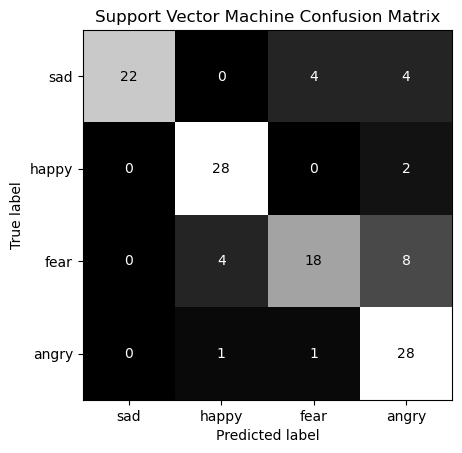

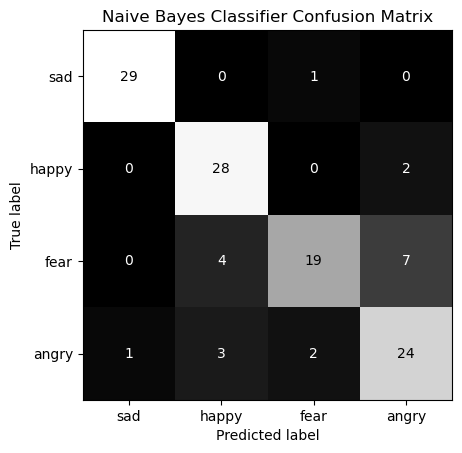

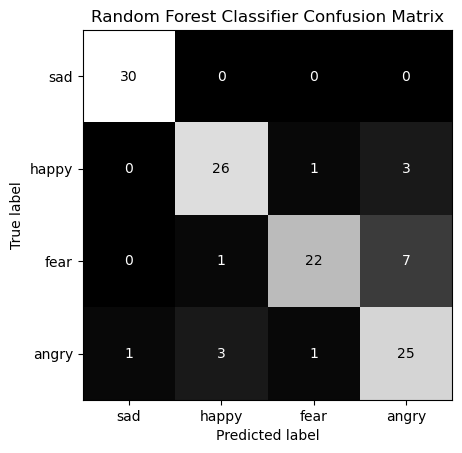

In [16]:
# Create inverse mapping
emotion_mapping = {0: 'sad', 1: 'happy', 2: 'fear', 3: 'angry'}

# Convert integer predictions to emotion labels
y_svc_predicted_labels = [emotion_mapping[pred] for pred in y_svc_predicted]
y_nbc_predicted_labels = [emotion_mapping[pred] for pred in y_nbc_predicted]
y_rfc_predicted_labels = [emotion_mapping[pred] for pred in y_rfc_predicted]

# Convert y_test to emotion labels
y_test_labels = [emotion_mapping[pred] for pred in y_test]

# Display classification reports with emotion labels as target names
print(classification_report(y_test_labels, y_svc_predicted_labels, target_names=list(emotion_mapping.values())))
print(classification_report(y_test_labels, y_nbc_predicted_labels, target_names=list(emotion_mapping.values())))
print(classification_report(y_test_labels, y_rfc_predicted_labels, target_names=list(emotion_mapping.values())))

models = ['Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']

# Plot confusion matrices
plot = 1

for model, prediction in zip(models, [y_svc_predicted_labels, y_nbc_predicted_labels, y_rfc_predicted_labels]):
    # Create a confusion matrix with emotion labels
    cm = confusion_matrix(y_test_labels, prediction, labels=list(emotion_mapping.values()))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_mapping.values()))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")